## Loading Tools


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import resample

In [2]:
# Load the dataset
df = pd.read_csv('NYCdataset.csv')

In [3]:
# Drop unnecessary columns
columnsToDrop = [
    'Title Code No', 
    'Work Location 1', 
    'Recruitment Contact', 
    'Residency Requirement', 
    'To Apply', 
    'Post Until', 
    'Process Date', 
    'Posting Updated',
    'Posting Type', 
    'Civil Service Title', 
    'Title Classification', 
    'Division/Work Unit', 
    'Hours/Shift', 
    'Additional Information', 
    'Full-Time/Part-Time indicator'
]
newdf = df.drop(columns=columnsToDrop)

In [4]:
newdf.drop_duplicates(inplace=True)


In [5]:
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = ' '.join(text.split())  # Remove extra whitespace
    text = text.replace('\n', ' ').replace('\r', ' ')  # Remove special characters
    return text

In [6]:
# Apply the cleaning function to relevant columns, handling NaN values
newdf['Job Description'] = newdf['Job Description'].fillna('').apply(clean_text)
newdf['Minimum Qual Requirements'] = newdf['Minimum Qual Requirements'].fillna('').apply(clean_text)
newdf['Preferred Skills'] = newdf['Preferred Skills'].fillna('').apply(clean_text)

# Merge relevant text columns into a single 'features' column
newdf['features'] = newdf['Job Description'] + ' ' + \
                    newdf['Minimum Qual Requirements'] + ' ' + \
                    newdf['Preferred Skills']

In [7]:
# Filter the dataset to include necessary columns
cleanData = newdf.filter(items=['Job ID',  'Job Category', 'features'])


In [8]:
# Resampling to balance the data
max_count = cleanData['Job Category'].value_counts().max()
balanced_data = []
for category in cleanData['Job Category'].unique():
    category_data = cleanData[cleanData['Job Category'] == category]
    if len(category_data) < max_count:
        balance_cat_data = resample(category_data, replace=True, n_samples=max_count, random_state=42)
    else:
        balance_cat_data = resample(category_data, replace=False, n_samples=max_count, random_state=42)
    balanced_data.append(balance_cat_data)

# Concatenate all balanced data
balance_df = pd.concat(balanced_data)

In [9]:
# Reset the index
balance_df.reset_index(drop=True, inplace=True)

In [10]:
balance_df['Job Category'].value_counts()

Constituent Services & Community Programs                                                                                                                                                                                   377
Communications & Intergovernmental Affairs Legal Affairs Policy, Research & Analysis Public Safety, Inspections, & Enforcement                                                                                              377
Administration & Human Resources Constituent Services & Community Programs Engineering, Architecture, & Planning Building Operations & Maintenance Policy, Research & Analysis Public Safety, Inspections, & Enforcement    377
Communications & Intergovernmental Affairs Finance, Accounting, & Procurement Policy, Research & Analysis                                                                                                                   377
Constituent Services & Community Programs Communications & Intergovernmental Affairs Legal Affairs Publi

In [11]:
# Sampling a smaller portion of the data (70% of the balanced dataset)
small_sample = balance_df.sample(frac=0.7, random_state=42)

# Splitting the sample data for training and testing
x_sample = small_sample['features']
y_sample = small_sample['Job Category']

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x_sample, y_sample, test_size=0.2, random_state=42)


In [13]:
# Limiting the features in TF-IDF vectorization to speed up processing
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
x_test_tfidf = tfidf_vectorizer.transform(x_test)

In [14]:
# Initialize RandomForestClassifier with fewer trees and parallel processing
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(x_train_tfidf, y_train)

RandomForestClassifier(random_state=42)

In [15]:
# Predictions and evaluation
y_pred = rf_classifier.predict(x_test_tfidf)

In [16]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')



Accuracy: 0.9906


In [17]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)



Confusion Matrix:
 [[61  0  0 ...  0  0  0]
 [ 0 35  0 ...  0  0  0]
 [ 0  0 58 ...  0  0  0]
 ...
 [ 0  0  0 ... 48  0  0]
 [ 0  0  0 ...  0 46  0]
 [ 0  0  0 ...  0  0 41]]


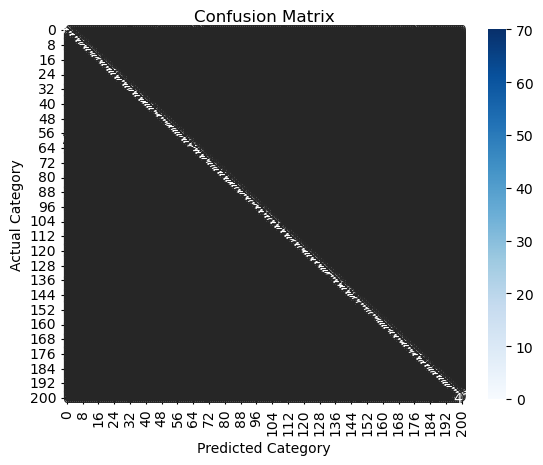

In [18]:
# Plotting the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual Category')
plt.xlabel('Predicted Category')
plt.title('Confusion Matrix')
plt.show()

In [19]:
# Function to process the CV
def process_cv(cv_text):
    cleaned_cv = clean_text(cv_text)
    cv_tfidf = tfidf_vectorizer.transform([cleaned_cv])
    return cv_tfidf

In [22]:
# Function to recommend jobs based on CV
def recommend_jobs(cv_text, top_n=5):
    # Process the CV
    cv_features = process_cv(cv_text)
    
    # Predict job category from CV
    predicted_category = rf_classifier.predict(cv_features)[0]
    
    # Filter job listings with the predicted category
    matching_jobs = balance_df[balance_df['Job Category'] == predicted_category]
    
    # Output top N job recommendations
    print(f"\nRecommended jobs for category '{predicted_category}':\n")
    recommended_jobs = matching_jobs[['Job ID', 'Job Category', 'features']].head(top_n)
    
    for idx, row in recommended_jobs.iterrows():
        print(f"Job ID: {row['Job ID']}")
        print(f"Job Category: {row['Job Category']}")
        print(f"Job Description: {row['features'][:200]}...")  # Show first 200 characters of job description
        print("\n")

In [21]:
# Prompt user to input CV text
cv_text = input("Please input your CV content here:\n")


Please input your CV content here:
 John Doe  Contact Information:  Email: johndoe@email.com Phone: (123) 456-7890 Address: 123 Finance Street, New York, NY 10001 Professional Summary: Results-driven finance professional with over 5 years of experience in accounting, financial analysis, and procurement management. Adept at optimizing financial processes, conducting detailed financial analysis, and managing budgets. Strong knowledge of procurement strategies, vendor negotiations, and cost-saving techniques. Proficient in financial software and ERP systems.  Core Competencies: Financial Reporting Budgeting & Forecasting Cost Control & Analysis Vendor Management & Procurement Accounts Payable/Receivable ERP Systems (SAP, Oracle) Contract Negotiation Audit Support Risk Management Professional Experience: Senior Financial Analyst XYZ Corporation | New York, NY | January 2020 – Present  Prepare financial statements, reports, and forecasts to support business decision-making. Analyze budget v

In [22]:
# Recommend jobs based on the input CV
recommend_jobs(cv_text, top_n=5)


Recommended jobs for category 'Finance, Accounting, & Procurement':

Job ID: 590950
Job Category: Finance, Accounting, & Procurement
Job Description: note: all applicants must be current city of new york employees serving in a permanent (not provisional) civil service title of management auditor or accountant. the office of the new york city comptr...


Job ID: 590406
Job Category: Finance, Accounting, & Procurement
Job Description: * important note** only those serving as a permanent procurement analyst** the nyc department of environmental protection (dep) enriches the environment and protects public health for all new yorkers ...


Job ID: 556917
Job Category: Finance, Accounting, & Procurement
Job Description: ***important note: only those currently serving as a permanent or probable permanent administrative procurement analyst non-manager will be considered.*** the nyc department of environmental protectio...


Job ID: 598714
Job Category: Finance, Accounting, & Procurement
Job D